# Investments Project (Spring 2024)

**Authors:**
- Marc-Antoine Allard
- Adam Zinebi
- Paul Teiletche
- ...

**DUE Date: June 21 at 23:59**

---
# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from utils import plot_metrics

%load_ext autoreload 
%autoreload 2

In [48]:
DATA_PATH = "../data"

---
# 4 - Momentum Strategy (Mom)

*a) Construct the return to a long-short momentum strategy portfolio. To that effect every month sort stocks into deciles based on their 1-month lagged 11-month return (that is in month $t$ rank stocks based on their $t$−12 to $t$−1 cumulative return). <br></br> Then compute monthly returns for 10 decile portfolios that equal weight all stocks in each decile. Plot the average annualized portfolio mean, standard deviation, and Sharpe ratios across the 10 deciles in three bar plots. Repeat for value-weighted decile portfolios. Is the evidence consistent with the CAPM?*

In [3]:
# Load the data
data = pd.read_parquet(f'{DATA_PATH}/stock_data.parquet')

display(data.head())
data.shape

,permno,date,Rn,shrout,prc,siccd,Rm,rf,mcap,mcap_l,Rn_f,const,Rn_e,Rm_e,w_m
5,10001,2010-01-29,-0.018932,4361.0,10.0600,4925,-0.037172,0.000013,43871.6600,44918.3000,-0.000656,1,-0.018945,-0.037185,0.000005
4,10001,2010-02-26,-0.000656,4361.0,10.0084,4925,0.034744,0.000061,43646.6324,43871.6600,0.020643,1,-0.000717,0.034683,0.000005
3,10001,2010-03-31,0.020643,4361.0,10.1700,4925,0.063668,0.000112,44351.3700,43646.6324,0.124385,1,0.020531,0.063556,0.000005
2,10001,2010-04-30,0.124385,6070.0,11.3900,4925,0.020036,0.000118,69137.3000,44351.3700,0.004829,1,0.124267,0.019918,0.000004
1,10001,2010-05-28,0.004829,6071.0,11.4000,4925,-0.079240,0.000114,69209.4000,69137.3000,-0.043421,1,0.004715,-0.079354,0.000007


(1425495, 15)

In [4]:
from tqdm.auto import tqdm  # for notebooks
tqdm.pandas()

# Ensure date is in datetime format
data['date'] = pd.to_datetime(data['date'])

# Calculate cumulative returns for each stock over the past 11 months
data['cum_Rn'] = data.groupby('permno')['Rn'].rolling(11).progress_apply(lambda x: np.prod(1 + x) - 1).reset_index(level=0, drop=True)

# Remove rows with NaN cumulative returns
data = data.dropna(subset=['cum_Rn'])

# Sort stocks into deciles based on cumulative return
data['decile'] = data.groupby('date')['cum_Rn'].transform(lambda x: pd.qcut(x, 10, labels=False) + 1)

data.to_parquet(f'{DATA_PATH}/deciles/mom_deciles.parquet')

data['decile'].head()

0it [00:00, ?it/s]

87    4
86    3
85    4
84    5
83    4
Name: decile, dtype: int64

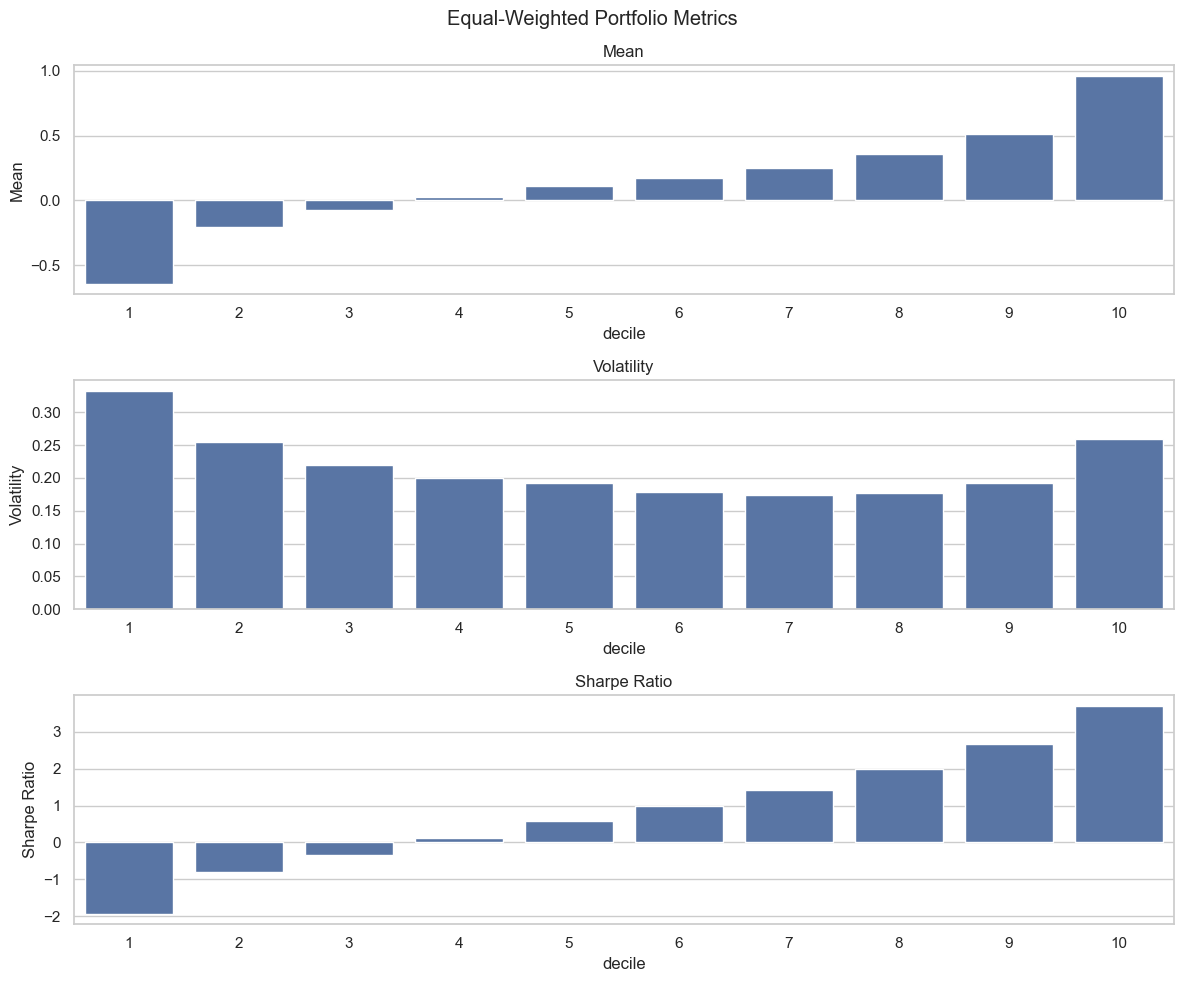

In [5]:
# Compute equal-weighted returns for each decile
ew_returns = data.groupby(['date', 'decile'])['Rn'].mean().unstack()

# Plotting the decile annual metrics
plot_metrics(ew_returns, 'Equal-Weighted Portfolio Metrics')

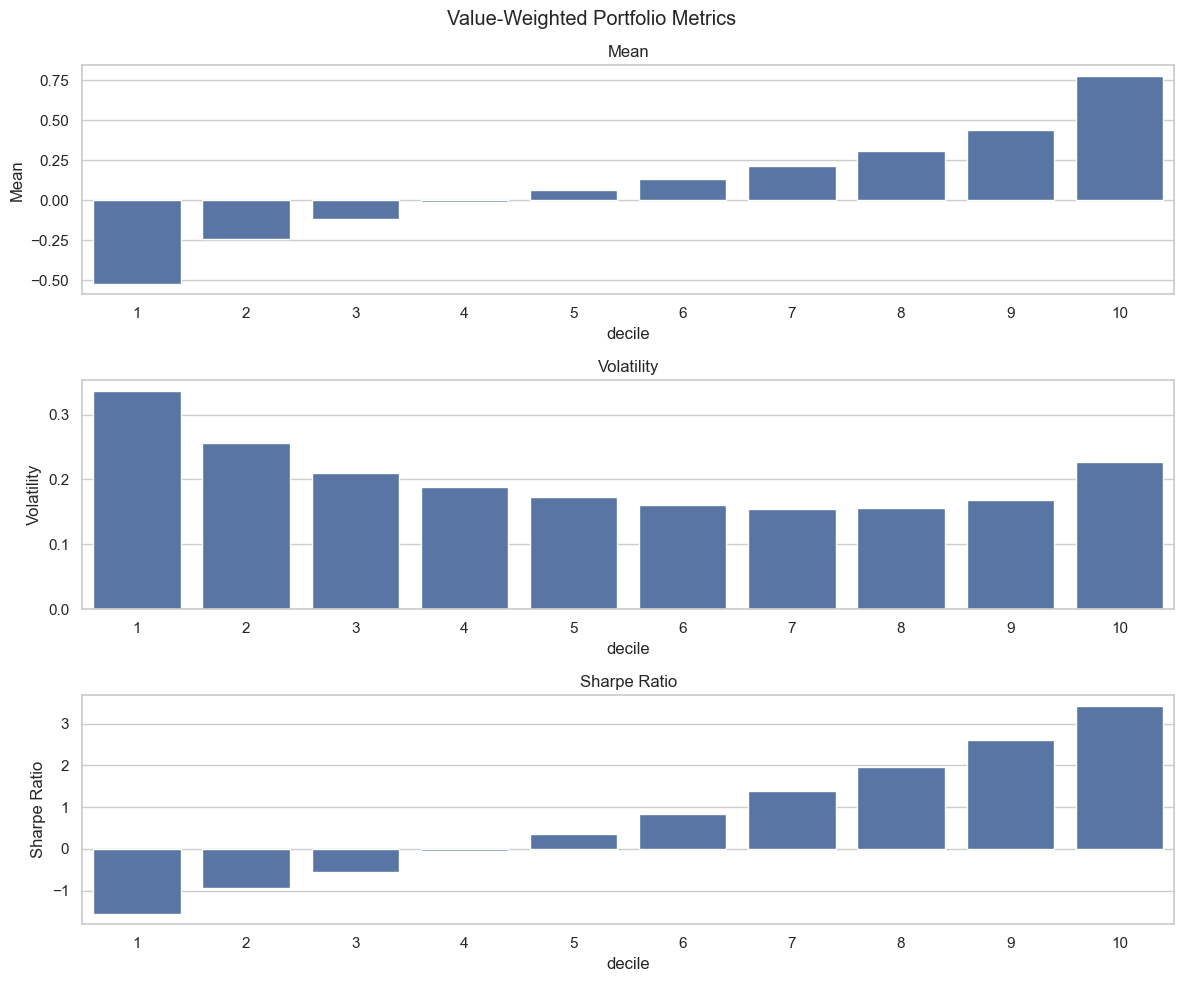

In [6]:
# Compute value-weighted returns for each decile
vw_returns = data.groupby(['date', 'decile']).apply(lambda x: np.average(x['Rn'], weights=x['mcap'])).unstack()

# Plotting the decile annual metrics
plot_metrics(vw_returns, 'Value-Weighted Portfolio Metrics')

*b) The momentum strategy is then the portfolio that goes long the three highest deciles and short the three lowest decile portfolios. Compute and compare the mean, stan- dard deviation, and Sharpe ratios of the long and short legs of the strategy as well as of the strategy itself. Test if the strategy has an average return that is statistically significantly different from zero. Repeat both tests for equal and value-weighted portfolios.*

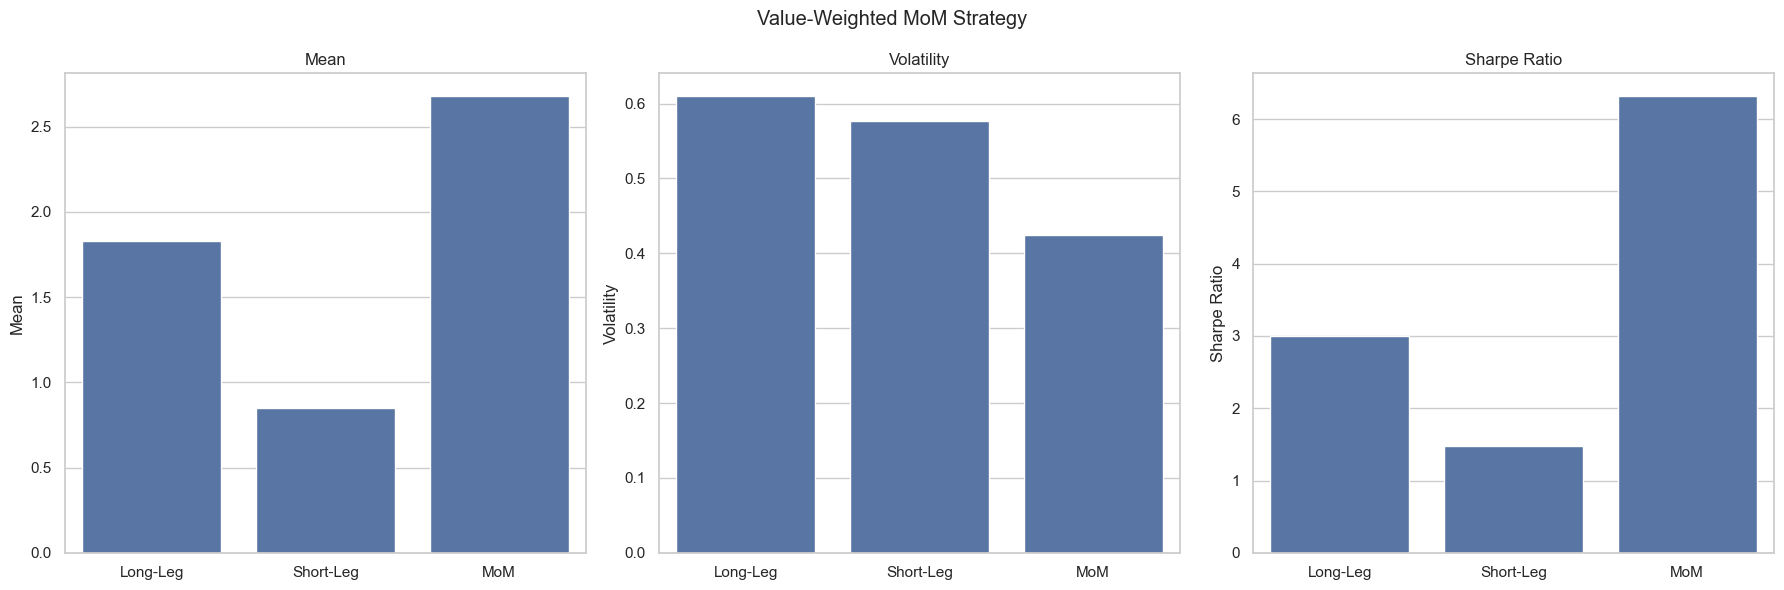

Equal-Weighted Long-Short Strategy: t-stat=48.516257991121584, p-value=3.6279670901052745e-227


In [43]:
# Long-Short Momentum Portfolio
long_ew = ew_returns.loc[:, 8:10].sum(axis=1)
short_ew = - ew_returns.loc[:, 0:2].sum(axis=1)
mom_ew = long_ew + short_ew

# Plot strategy performance
plot_metrics(pd.DataFrame({'Long-Leg': long_ew,     
                            'Short-Leg': short_ew, 
                            'MoM': mom_ew}), 'Value-Weighted MoM Strategy')

# Statistical significance testing
t_stat_equal, p_value_equal = stats.ttest_1samp(mom_ew, 0)
print(f"Equal-Weighted Long-Short Strategy: t-stat={t_stat_equal}, p-value={p_value_equal}")

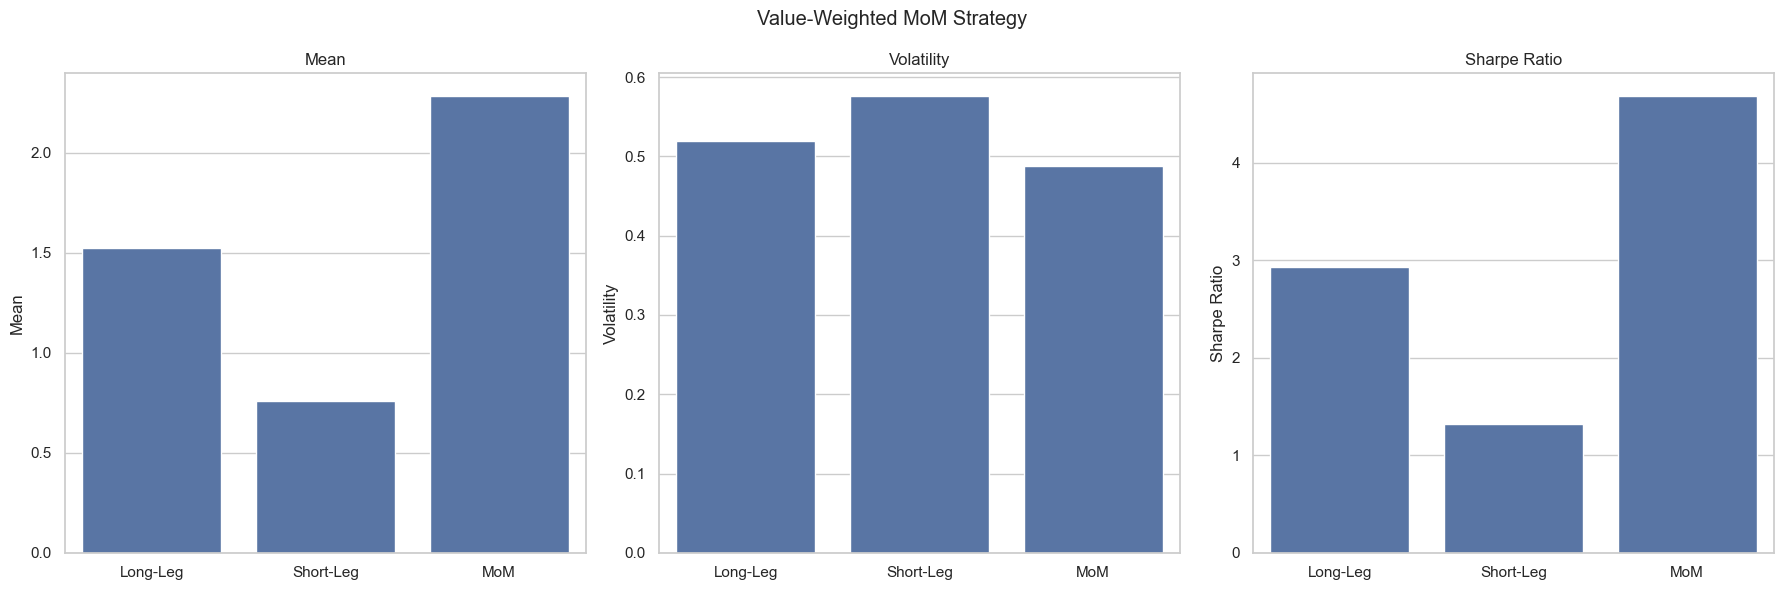

Value-Weighted Long-Short Strategy: t-stat=35.950304352316955, p-value=9.361451362160415e-162


In [44]:
# Step 4: Long-Short Momentum Portfolio
long_vw = vw_returns.loc[:, 8:10].sum(axis=1)
short_vw = - vw_returns.loc[:, 0:2].sum(axis=1)
mom_vw = long_vw + short_vw

# Plot strategy performance
plot_metrics(pd.DataFrame({'Long-Leg': long_vw,     
                            'Short-Leg': short_vw, 
                            'MoM': mom_vw}), 'Value-Weighted MoM Strategy')

# Statistical significance testing
t_stat_value, p_value_value = stats.ttest_1samp(mom_vw, 0)
print(f"Value-Weighted Long-Short Strategy: t-stat={t_stat_value}, p-value={p_value_value}")

In [46]:
mom_df = mom_vw.reset_index().rename(columns={0: 'MoM'})
mom_df

,date,MoM
0,1964-12-31,0.095972
1,1965-01-29,0.107979
2,1965-02-26,0.132607
3,1965-03-31,0.134099
4,1965-04-30,0.244512
...,...,...
703,2023-08-31,0.342385
704,2023-09-29,0.133265
705,2023-10-31,0.144509
706,2023-11-30,0.393881


In [49]:
mom_df.to_parquet(f'{DATA_PATH}/factors/mom_returns.parquet')